In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'testis_testis_HCLFetalMaleGonad2'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/testis_testis_HCLFetalMaleGonad2/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [6]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalMaleGonad_2.GCAGGAGCCTAGCATCCC,FetalMaleGonad_2.AACCTATATTGTCCAGAC,FetalMaleGonad_2.CTGTGTAGCGAGCCGACG,FetalMaleGonad_2.TTCATATCGTAAGAACGC,FetalMaleGonad_2.GCTGTGAGGACTAGGACT
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A1CF,0,0,0,0,0
A2M,0,0,0,0,0
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalMaleGonad_2.AACGCCTCGTAAATTCCA,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor9,Male,GW11
FetalMaleGonad_2.GCAGGAGCCTAGCATCCC,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor9,Male,GW11
FetalMaleGonad_2.AACCTATATTGTCCAGAC,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor9,Male,GW11
FetalMaleGonad_2.CTGTGTAGCGAGCCGACG,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor9,Male,GW11
FetalMaleGonad_2.TTCATATCGTAAGAACGC,Gonad,FetalMaleGonad,FetalMaleGonad,Healthy,Donor9,Male,GW11


[1] "Primordial germ cell" "Primordial germ cell" "Primordial germ cell"
[4] "Primordial germ cell" "Primordial germ cell"

In [7]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


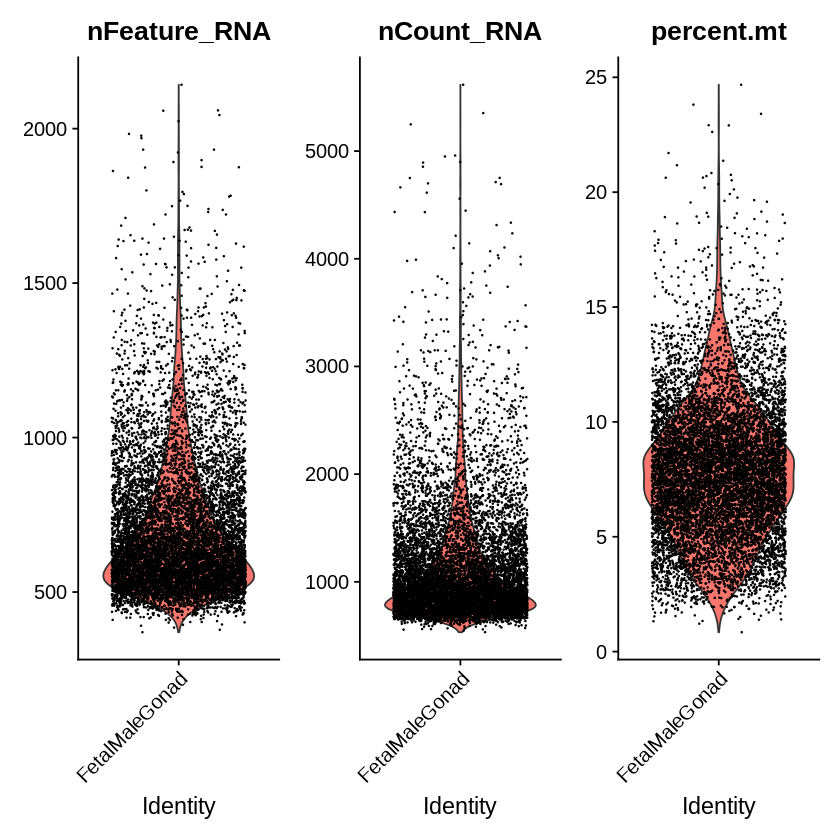

In [8]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [9]:
# QC
nFeature_RNA_range = c(200, 1500)
percent.mt.thre = 15
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [10]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  FOS, MT-RNR2, B2M, BTG2, NPY, DUSP1, HSPA1A, NR4A1, EGR2, CRYM 
	   SLC2A3, COL3A1, ID2, KRT18, KITLG, MT3, SPARC, TOX3, GADD45B, DIRAS3 
	   NPNT, ZFP36, FAM210B, CCDC73, HES1, ARL5B, NR4A2, VEGFA, EGR3, SPRR2F 
Negative:  POU5F1, TUBA1C, NDUFAB1, TCL1A, DPPA5, GTSF1, DNAJC15, HMGB3, RBM3, RPS6 
	   ACTG2, HENMT1, PDPN, PRDX1, RPSA, SLC25A5, PPM1N, RAN, SYCP3, KHDC3L 
	   DPPA4, LAMTOR5, CTSL, PMAIP1, APOC1, RPLP1, MND1, CCT2, PRDX4, RPS18 
PC_ 2 
Positive:  UBE2C, TOP2A, CDK1, PTTG1, HMGB2, NUSAP1, MAD2L1, CENPF, TUBA1B, CDCA3 
	   CCNB1, CDC20, NUF2, KIF23, MKI67, CCNA2, KIF20A, CDKN3, PBK, SMC4 
	   AURKB, NEK2, LGALS1, KIAA0101, PRC1, ARL6IP1, CCNB2, NDC80, DLGAP5, KIF2C 
Negative:  SAT1, POU5F1, CRYM, TCL1A, PPM1N, APOC1, FAM210B, MT3, GTSF1, PRDX1 
	   MT1L, DPPA5, KITLG, ACTG2, CD9, KHDC3L, LINC01356, NDUFAB1, CFLAR, GPHA2 
	   RBM3, CCDC73, NANOG, HENMT1, NPNT, PGK1, RPL27, EGR3, FTL, TOX3 
PC_ 3 
Positive:  UBE2C, CKS2, TOP2A, KPNA2, NUSAP1, PTTG1, HMGB2, AR

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


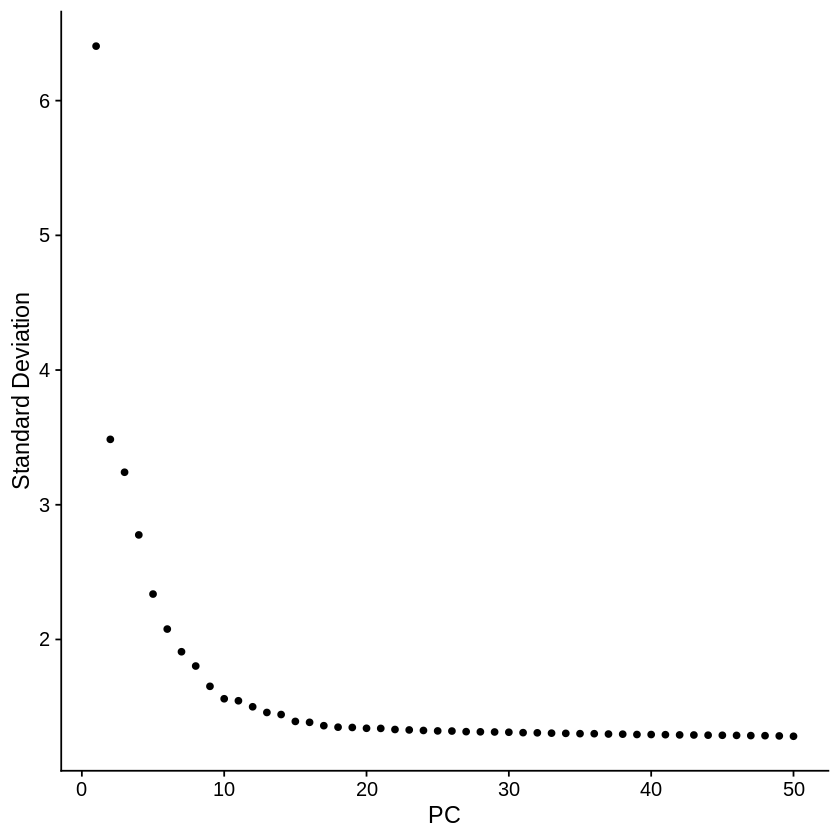

In [12]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [13]:
dev.off()
pcDim = 10 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:57:28 UMAP embedding parameters a = 0.9922 b = 1.112

16:57:28 Read 9604 rows and found 10 numeric columns

16:57:28 Using Annoy for neighbor search, n_neighbors = 30

16:57:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:57:29 Writing NN index file to temp file /tmp/RtmpZJf4lV/file62012b111670

16:57:29 Searching Annoy index using 1 thread, search_k = 3000

16:57:32 Annoy recall = 100%

16:57:32 Commencing smooth kNN distance calibration using 1 thread

16:57:33 Initializing fro

In [20]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.75)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9604
Number of edges: 307132

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8335
Number of communities: 11
Elapsed time: 1 seconds


17:01:14 UMAP embedding parameters a = 0.9922 b = 1.112

17:01:14 Read 9604 rows and found 10 numeric columns

17:01:14 Using Annoy for neighbor search, n_neighbors = 30

17:01:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:01:15 Writing NN index file to temp file /tmp/RtmpZJf4lV/file6201a00ce24

17:01:15 Searching Annoy index using 1 thread, search_k = 3000

17:01:18 Annoy recall = 100%

17:01:18 Commencing smooth kNN distance calibration using 1 thread

17:01:19 Initializing from normalized Laplacian + noise

17:01:19 Commencing optimization for 500 epochs, with 403118 positive edges

17:01:42 Optimization finished



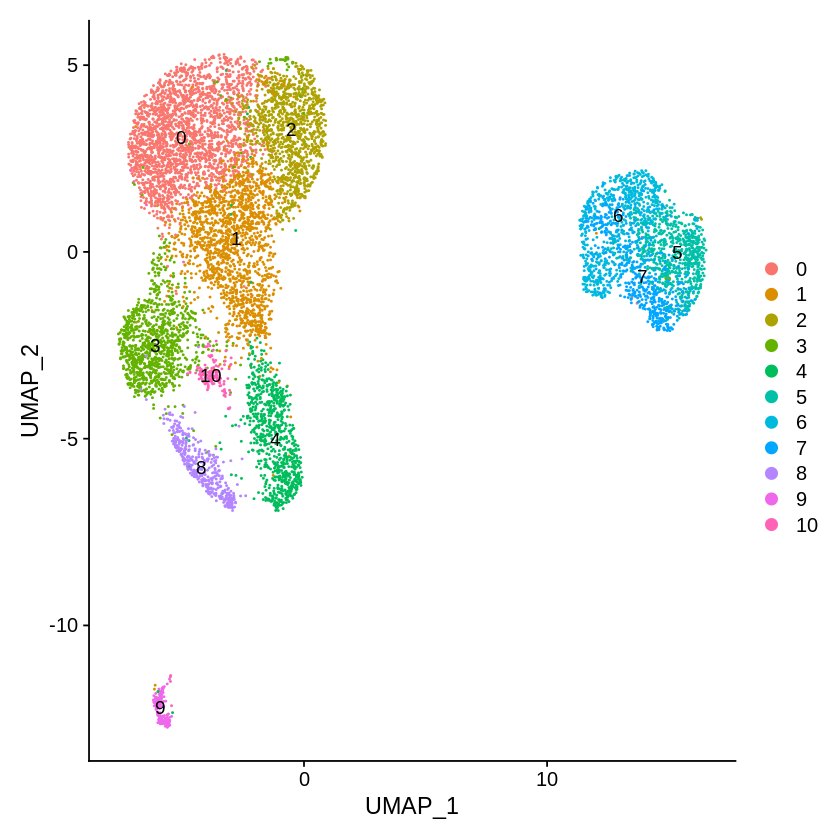

In [21]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [22]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

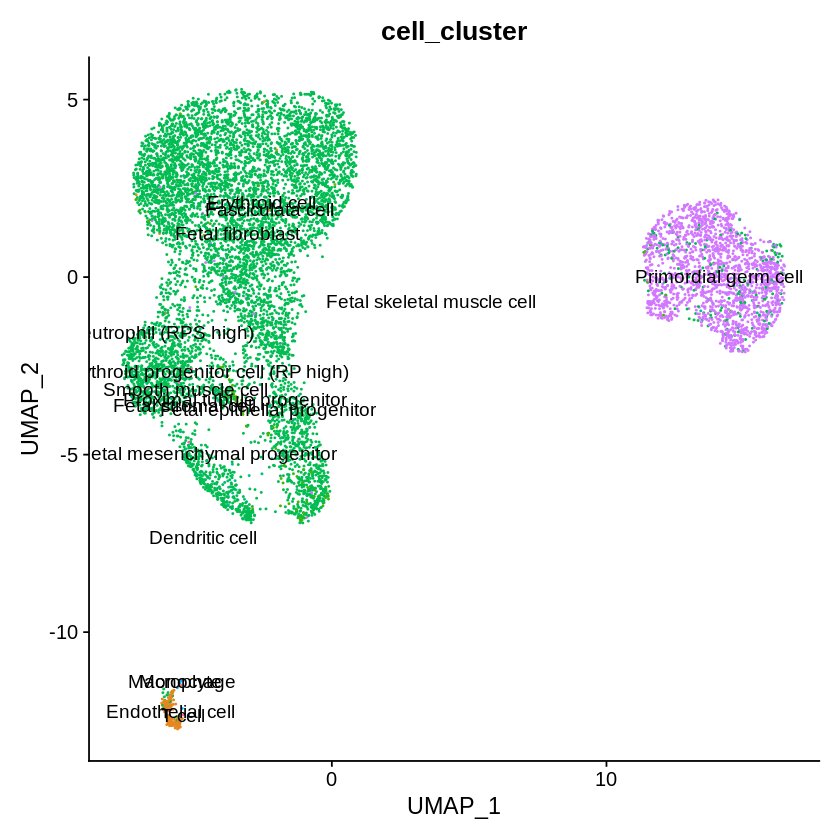

In [23]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [16]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [24]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



In [26]:
new.cluster.ids <- c("Testis-Connective tissue-NK T cell-MT-ATP6 MT-CYB",
                     "Testis-Connective tissue-Neutrophilic granulocyte-FOS CYSTM1",
                     "Testis-Connective tissue-Neutrophilic granulocyte/Basophilic granulocyte-NR4A2 EGR3/SELENOK",
                     "Testis-Connective tissue-Fibroblast-DCN COL1A1 COL1A2",
                     "Testis-Epithelial tissue-Spermatogonial stem cell-TOP2A",
                     "Testis-Epithelial tissue-Spermatogenic cell-POU5F1 TCL1A",
                     "Testis-Epithelial tissue-Spermatogenic cell-MND1",
                     "Testis-Connective tissue-Neutrophilic granulocyte/Eosinophilic granulocyte-CXCL8 SRGN CCL3L3/RGS1 CCL3L3 CCL4L2",
                     "Testis-Epithelial tissue-Tubule cell-MMP7 CD24",
                     "Testis-Epithelial tissue-Endothelial cell-CD34",
                     "Testis-Connective tissue-Fibroblast-TM4SF1 MGP SULT1E1"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [27]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [28]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

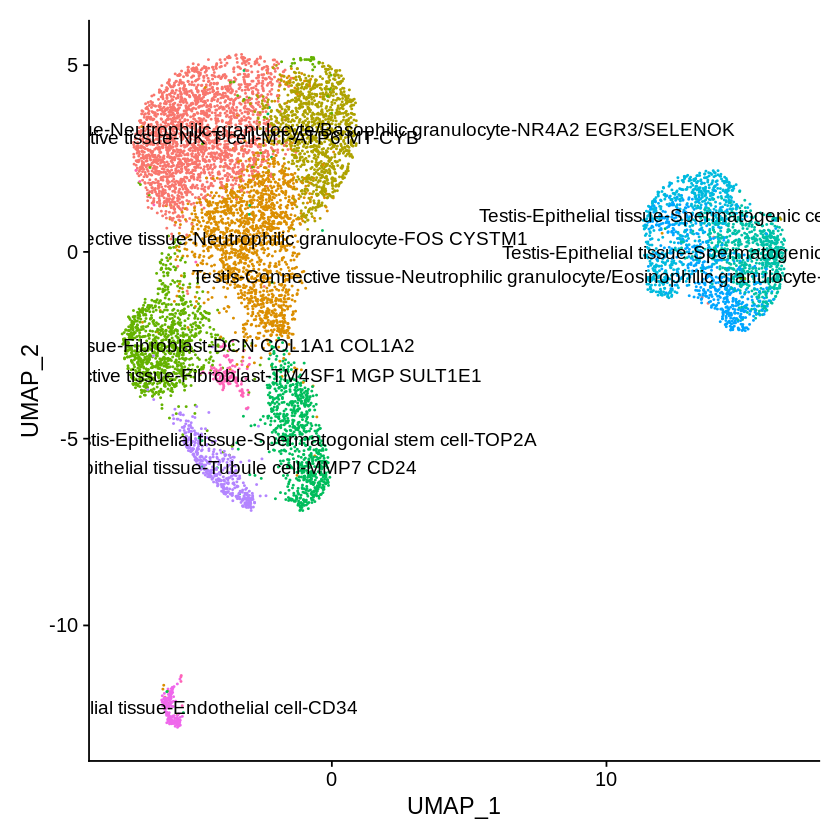

In [29]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [79]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))